<img src="../../images/BikeDNA_logo.svg" width="250"  alt="BikeDNA logo" style="display:block; margin-left: auto; margin-right: auto;">
<a href="https://github.com/anerv/BikeDNA">Github</a>

# 3a. Extrinsic Analysis: Comparison of OSM & Reference Data

This notebook compares the provided reference bicycle infrastructure data set with OSM data in the same area in a so-called extrinsic quality assessment. To run this part of the analysis, a reference data set thus must be available for comparison. 

This analysis is based on comparing the reference data set to OSM and highlighting how and where they differ, both in terms of *how much* bicycle infrastructure is mapped in the two data sets, and of *how* the infrastructure is mapped, pinpointing differences in network structure. 

**All differences are computed for the reference data in relation to OSM, taking the OSM data as the base line.** For example, the difference in network density is computed by calculating reference density minus OSM density. Hence, positive difference values (over 0) indicate how much higher the reference value is; negative difference values (below 0) indicate how much lower the reference value is. Accordingly, if differences are given in percent, the OSM value is taken to be the total value (100%).

While the analysis is based on a comparison, it makes no a priori assumptions about which data set is better. The same goes for the identified differences: BikeDNA does not allow an automatic conclusion as to which data set is of better quality, but instead requires the user to interpret the meaning of the differences found, e.g., whether differing features are results of errors of omission or commission, and which data set is more correct. However, many low values can be an indication that the reference data is of lower completeness than the OSM data.

The goal is that the identified differences can be used to both assess the quality of the reference and OSM data sets, and to support the decision of which data set should be used for further analysis.

<div class="alert alert-block alert-info">
<b>Prerequisites &amp; Input/Output</b>
<p>
The extrinsic comparison is based almost exclusively on results from notebooks 2a and 2b and expects results and plots to be stored using the file paths used in the previous notebooks. Notebooks 1a, 2a, 1b, and 2b must be run successfully before this notebook can be used. Detailed explanations of the applied concepts and metrics can be found in the intrinsic analysis notebooks (2a and 2b).
</p>
</div>

<div class="alert alert-block alert-info">
<b>Familiarity required</b>
<p>
For a correct interpretation of some of the metrics for spatial data quality, some familiarity with the area is necessary.
</p>
</div>

**Sections**
* [Data completeness](#Data-completeness)
    * [Network length](#Network-length)
    * [Network density](#Network-density)
* [Network topology](#Network-topology)
    * [Simplification outcomes](#Simplification-outcomes)
    * [Alpha, beta, and gamma indices](#Alpha,-beta,-and-gamma-indices)
    * [Dangling nodes](#Dangling-nodes)
    * [Under/overshoots](#Under/overshoots)
* [Network components](#Network-components)
    * [Disconnected components](#Disconnected-components)
    * [Component size distribution](#Component-size-distribution)
    * [Largest connected component](#Largest-connected-component)
    * [Missing links](#Missing-links)
    * [Components per grid cell](#Components-per-grid-cell)
    * [Component connectivity](#Component-connectivity)
* [Summary](#Summary)

<br />

In [7]:
# Load libraries, settings and data

import json
import pickle
import warnings
from collections import Counter

import contextily as cx
import folium
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import yaml
from matplotlib import cm
from collections import Counter

from src import evaluation_functions as eval_func
from src import graph_functions as graph_func
from src import plotting_functions as plot_func

# Read in dictionaries with settings
%run ../settings/yaml_variables.py
%run ../settings/plotting.py
%run ../settings/tiledict.py
%run ../settings/df_styler.py

# Load data
%run ../settings/load_osmdata.py
%run ../settings/load_refdata.py
%run ../settings/load_results.py

warnings.filterwarnings("ignore")

OSM graphs loaded successfully!
OSM data loaded successfully!
Reference graphs loaded successfully!
Reference data loaded successfully!
Results from intrinsic analyses loaded successfully!


<div class="alert alert-block alert-info">
<b>User configurations</b>
<br>
<br>
For large datasets, the plotting can take as long as the actual analysis, if not more.
To allow for a faster execution of the notebook, use the above setting to control whether results are plotted or not. This only affects the plotting of new static and interactive maps - bar plots and maps from the intrinsic analyses are always plotted.
</div>

In [8]:
# USER INPUT: SET PLOTTING OF STATIC AND INTERACTIVE MAPS TO TRUE OF FALSE
plot_static_maps = False
plot_interactive_maps = False

for s in [plot_static_maps, plot_interactive_maps]:
    assert isinstance(s, bool), print(
        "Settings must be True or False!"
    )

print(f"Running notebook with plotting setting for static maps set to: {plot_static_maps}")
print(f"Running notebook with plotting setting for interactive maps set to: {plot_interactive_maps}")

Running notebook with plotting setting for static maps set to: False
Running notebook with plotting setting for interactive maps set to: False


**OSM versus reference network**

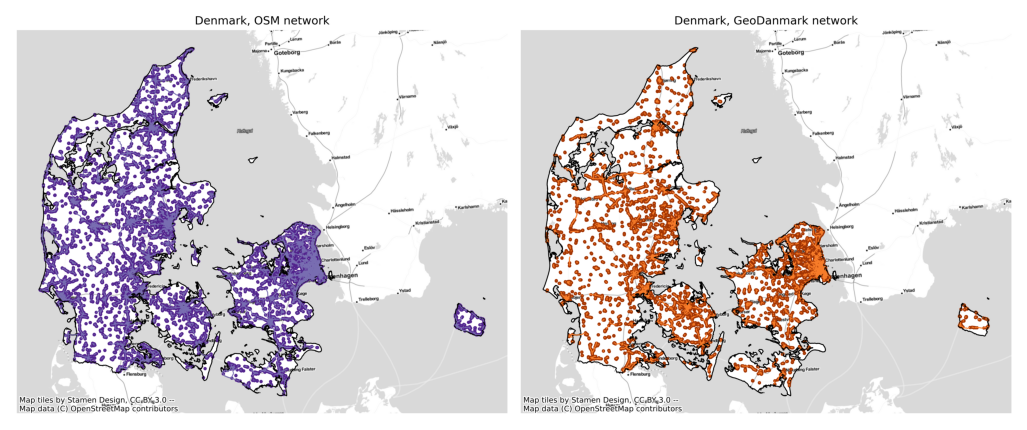

In [9]:
plot_func.plot_saved_maps(
    [
        osm_results_static_maps_fp + "area_network_osm",
        ref_results_static_maps_fp + "area_network_reference",
    ]
)

## Data completeness

This section compares the OSM and reference data sets in terms of data completeness. The goal is to identify whether one data set has more bicycle infrastructure mapped than the other, and if so, whether those differences are concentrated in some areas.

The section starts with a comparison of the total length of the infrastructure in both data sets. Then, infrastructure, node and dangling node densities (i.e., the length of infrastructure/nodes per km2) is compared first at a global (study area) and at local (grid cell) level. Finally, density differences for protected and unprotected bicycle infrastructure are compared separately.

Computing gridded local density differences as a measure of data quality has also been applied by e.g. [Haklay (2010)](https://journals-sagepub-com.ep.ituproxy.kb.dk/doi/10.1068/b35097).

**Method**

To account for differences in how bicycle infrastructure has been mapped, the computation of network length and density is based on the infrastructure length, not the geometric length of the network edges. For example, a 100 meter long **bi**directional path (geometric length: 100m) contributes with 200 meters of bicycle infrastructure (infrastructure length: 200m).

**Interpretation**

Density differences can point to incomplete data. For instance, if a grid cell has a significantly higher edge density in the OSM than in the reference data set, this can indicate unmapped, missing features in the reference data set, or that a street mistakenly has been tagged as bicycle infrastructure in OSM.

### Network length

In [10]:
plot_func.compare_print_network_length(
    osm_edges_simplified.infrastructure_length.sum(),
    ref_edges_simplified.infrastructure_length.sum(),
)

Length of the OSM data set: 20582.93 km
Length of the reference data set: 8675.52 km


The reference data set is 11907.41 km shorter than the OSM data set.
The reference data set is 57.85% shorter than the OSM data set.


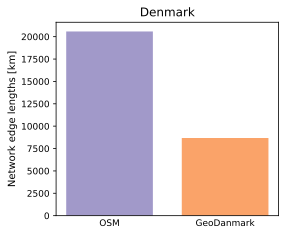

In [11]:
# Plot length comparison

set_renderer(renderer_plot)

bar_labels = ["OSM", reference_name]
x_positions = [1, 2]
bar_colors = [pdict["osm_base"], pdict["ref_base"]]

# Infrastructure length density
data = [osm_edges_simplified.infrastructure_length.sum()/1000,
        ref_edges_simplified.infrastructure_length.sum()/1000
    ]
y_label = "Network edge lengths [km]"
filepath = compare_results_plots_fp + "network_length_compare"
title = area_name

plot = plot_func.make_bar_plot(
    data=data,
    bar_labels=bar_labels,
    y_label=y_label,
    x_positions=x_positions,
    title=title,
    bar_colors=bar_colors,
    filepath=filepath,
    figsize=pdict["fsbar_small"]
)

### Network Density

#### Global network densities

In [12]:
plot_func.print_network_densities(osm_intrinsic_results, "OSM")
plot_func.print_network_densities(ref_intrinsic_results, "reference")

In the OSM data, there are:
 - 444.38 meters of cycling infrastructure per km2.
 - 1.98 nodes in the cycling network per km2.
 - 1.01 dangling nodes in the cycling network per km2.


In the reference data, there are:
 - 187.30 meters of cycling infrastructure per km2.
 - 1.11 nodes in the cycling network per km2.
 - 0.24 dangling nodes in the cycling network per km2.




**Global network densities (per km2)**

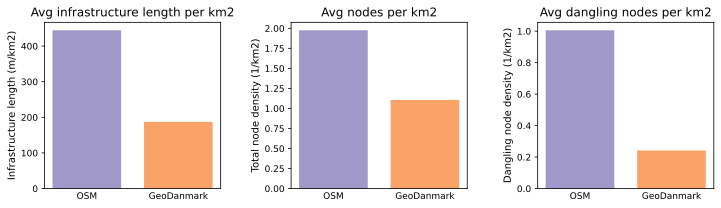

In [13]:
# Plot global difference

set_renderer(renderer_plot)

# Infrastructure length density
subplotdata = [
    (
        osm_intrinsic_results["network_density"]["edge_density_m_sqkm"],
        ref_intrinsic_results["network_density"]["edge_density_m_sqkm"],
    ),
    (
        osm_intrinsic_results["network_density"]["node_density_count_sqkm"],
        ref_intrinsic_results["network_density"]["node_density_count_sqkm"],
    ),
    (
        osm_intrinsic_results["network_density"]["dangling_node_density_count_sqkm"],
        ref_intrinsic_results["network_density"]["dangling_node_density_count_sqkm"],
    ),
]
subplotx_positions = [[1,2] for j in range(3)]
subplotbar_labels = [
    "Infrastructure length (m/km2)",
    "Total node density (1/km2)",
    "Dangling node density (1/km2)",
]
filepath = compare_results_plots_fp + "network_densities_compare"
subplottitle = [
    "Avg infrastructure length per km2",
    "Avg nodes per km2",
    "Avg dangling nodes per km2",
]

plot = plot_func.make_bar_subplots(
    subplot_data=subplotdata,
    nrows=1,
    ncols=3,
    bar_labels=[["OSM", reference_name] for j in range(3)],
    y_label=subplotbar_labels,
    x_positions=subplotx_positions,
    title=subplottitle,
    bar_colors=[pdict["osm_base"], pdict["ref_base"]],
    filepath=filepath,
    wspace=0.4
)

#### Local network densities

In [14]:
### Plot density comparisons

if plot_static_maps:

    set_renderer(renderer_map)

    # Edge density
    plot_cols = ["osm_edge_density", "ref_edge_density"]
    plot_func.plot_multiple_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=["OSM edge density", f"{reference_name} edge density"],
        filepath=compare_results_static_maps_fp + "density_edge_compare",
        cmap=pdict["pos"],
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=["count_osm_edges", "count_ref_edges"],
        use_norm=True,
        norm_min=0,
        norm_max = max(grid[plot_cols].max()),
        figsize = pdict["fsmap"],
        legend = False,
    )

    # Node density
    plot_cols = ["osm_node_density", "ref_node_density"]
    plot_func.plot_multiple_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=["OSM node density", f"{reference_name} node density"],
        filepath=compare_results_static_maps_fp + "density_node_compare",
        cmap=pdict["pos"],
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=["count_osm_nodes", "count_ref_nodes"],
        use_norm=True,
        norm_min=0,
        norm_max = max(grid[plot_cols].max()),
        figsize = pdict["fsmap"],
        legend = False,
    )

    # Dangling node density
    plot_cols = ["osm_dangling_node_density", "ref_dangling_node_density"]
    plot_func.plot_multiple_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=["OSM dangling node density", f"{reference_name} dangling node density"],
        filepath=compare_results_static_maps_fp + "density_danglingnode_compare",
        cmap=pdict["pos"],
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=["count_osm_nodes", "count_ref_nodes"],
        use_norm=True,
        norm_min=0,
        norm_max = max(grid[plot_cols].max()),
        figsize = pdict["fsmap"],
        legend = False,
    )

**Local differences in network densities**

The densities in the OSM data are taken as base line for comparison, with absolute differences computed as `reference value` - `OSM value`. Hence, positive values indicate that the reference density of the infrastructure type is higher than the OSM density; negative values indicate that the reference density is lower than the OSM density.

In [15]:
grid["edge_density_diff"] = grid.ref_edge_density.fillna(
    0
) - grid.osm_edge_density.fillna(0)

grid["node_density_diff"] = grid.ref_node_density.fillna(
    0
) - grid.osm_node_density.fillna(0)

grid["dangling_node_density_diff"] = grid.ref_dangling_node_density.fillna(
    0
) - grid.osm_dangling_node_density.fillna(0)

In [16]:
# Network density grid plots

if plot_static_maps:
    
    set_renderer(renderer_map)

    plot_cols = ["edge_density_diff", "node_density_diff", "dangling_node_density_diff"]
    plot_titles = [
        area_name + f": {reference_name} edge density differences to OSM (m/km2)",
        area_name + f": {reference_name} node density differences to OSM (m/km2)",
        area_name + f": {reference_name} dangling node density differences to OSM (m/km2)"
    ]
    filepaths = [
        compare_results_static_maps_fp + "edge_density_compare",
        compare_results_static_maps_fp + "node_density_compare",
        compare_results_static_maps_fp + "dangling_node_density_compare",
    ]

    cmaps = [pdict["diff"]] * 3

    # Cols for no-data plots
    no_data_cols = [
        ("osm_edge_density", "ref_edge_density"),
        ("osm_node_density", "ref_node_density"),
        ("osm_dangling_node_density", "ref_dangling_node_density"),
    ]

    cblim_edge = max(
        abs(min(grid["edge_density_diff"].fillna(value=0))),
        max(grid["edge_density_diff"].fillna(value=0)),
    )

    cblim_node = max(
        abs(min(grid["node_density_diff"].fillna(value=0))),
        max(grid["node_density_diff"].fillna(value=0)),
    )

    cblim_d_node = max(
        abs(min(grid["dangling_node_density_diff"].fillna(value=0))),
        max(grid["dangling_node_density_diff"].fillna(value=0)),
    )

    norm_min = [-cblim_edge, -cblim_node, -cblim_d_node]
    norm_max = [cblim_edge, cblim_node, cblim_d_node]

    plot_func.plot_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=plot_titles,
        filepaths=filepaths,
        cmaps=cmaps,
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=no_data_cols,
        use_norm=True,
        norm_min=norm_min,
        norm_max=norm_max,
    )

#### Densities of protected and unprotected bicycle infrastructure

**Global network densities for protected/unprotected infrastructure**

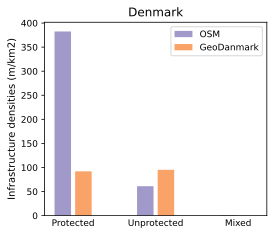

In [17]:
# Plot global differences


set_renderer(renderer_plot)

data_labels = ["protected_density", "unprotected_density", "mixed_density"]
legend_labels = ["OSM", reference_name]
data_osm = [
    osm_intrinsic_results["network_density"][label + "_m_sqkm"] for label in data_labels
]
data_ref = [
    ref_intrinsic_results["network_density"][label + "_m_sqkm"] for label in data_labels
]
bar_colors = [pdict["osm_base"], pdict["ref_base"]]
title = f"{area_name}"

x_labels = ["Protected", "Unprotected", "Mixed"]
x_axis = [np.arange(len(x_labels)) * 2 - 0.25, np.arange(len(x_labels)) * 2 + 0.25]
x_ticks = np.arange(len(x_labels)) * 2

y_label = "Infrastructure densities (m/km2)"

filepath = compare_results_plots_fp + "infrastructure_type_density_diff_compare"

fig = plot_func.make_bar_plot_side(
    x_axis=x_axis,
    data_osm=data_osm,
    data_ref=data_ref,
    bar_colors=bar_colors,
    legend_labels=legend_labels,
    title=title,
    x_ticks=x_ticks,
    x_labels=x_labels,
    x_label=None,
    y_label=y_label,
    filepath=filepath,
    figsize=pdict["fsbar_small"]
)

**Local network densities for protected/unprotected infrastructure**

In [18]:
if plot_static_maps:
    
    if "ref_protected_density" in grid.columns:

        plot_func.plot_saved_maps(
            [
                osm_results_static_maps_fp + "density_protected_OSM",
                ref_results_static_maps_fp + "density_protected_reference",
            ]
        )

    else:
        plot_func.plot_saved_maps(
            [osm_results_static_maps_fp + "density_protected_OSM"] * 2, alpha=[1, 0]
        )
        print(f"No infrastructure is mapped as protected in the {reference_name} data.")


    if "ref_unprotected_density" in grid.columns:

        plot_func.plot_saved_maps(
            [
                osm_results_static_maps_fp + "density_unprotected_OSM",
                ref_results_static_maps_fp + "density_unprotected_reference",
            ]
        )

    else:
        plot_func.plot_saved_maps(
            [osm_results_static_maps_fp + "density_unprotected_OSM"] * 2, alpha=[1, 0]
        )
        print(f"No infrastructure is mapped as unprotected in the {reference_name} data.")

    if "ref_mixed_density" in grid.columns:

        plot_func.plot_saved_maps(
            [
                osm_results_static_maps_fp + "density_mixed_OSM",
                ref_results_static_maps_fp + "density_mixed_reference",
            ]
        )

    else:
        plot_func.plot_saved_maps(
            [osm_results_static_maps_fp + "density_mixed_OSM"] * 2, alpha=[1, 0]
        )
        print(f"No infrastructure is mapped as mixed protected/unprotected in the {reference_name} data.")

**Differences in infrastructure type density**

In [19]:
# Computing difference in infrastructure type density

# In case no infrastructure with mixed protected/unprotected exist
if "osm_mixed_density" not in grid.columns:
    grid["osm_mixed_density"] = 0

if "ref_mixed_density" not in grid.columns:
    grid["ref_mixed_density"] = 0

if "ref_protected_density" not in grid.columns:
    grid["ref_protected_density"] = 0

if "ref_unprotected_density" not in grid.columns:
    grid["ref_unprotected_density"] = 0

grid["protected_density_diff"] = grid.ref_protected_density.fillna(
    0
) - grid.osm_protected_density.fillna(0)
grid["unprotected_density_diff"] = grid.ref_unprotected_density.fillna(
    0
) - grid.osm_unprotected_density.fillna(0)
grid["mixed_density_diff"] = grid.ref_mixed_density.fillna(
    0
) - grid.osm_mixed_density.fillna(0)

In [22]:
# Infrastructure type density grid plots

if plot_static_maps:
    
    set_renderer(renderer_map)

    plot_cols = ["protected_density_diff", "unprotected_density_diff", "mixed_density_diff"]
    plot_cols = [c for c in plot_cols if c in grid.columns]
    plot_titles = [
        area_name + f": {reference_name} protected infrastructure density differences to OSM (m/km2)",
        area_name + f": {reference_name} unprotected infrastructure density differences to OSM (1/km2)",
        area_name + f": {reference_name} mixed infrastructure density differences to OSM (1/km2)",
    ]

    filepaths = [
        compare_results_static_maps_fp + "protected_density_compare",
        compare_results_static_maps_fp + "unprotected_density_compare",
        compare_results_static_maps_fp + "mixed_density_compare",
    ]

    cmaps = [pdict["diff"]] * len(plot_cols)

    # Cols for no-data plots
    no_data_cols = [
        ("osm_edge_density", "ref_edge_density"),
        ("osm_edge_density", "ref_edge_density"),
        ("osm_edge_density", "ref_edge_density"),
    ]

    # Create symmetrical color range around zero
    cblim = max(
        abs(min(grid[plot_cols].fillna(value=0).min())),
        max(grid[plot_cols].fillna(value=0).max()),
    )

    norm_min = [-cblim] * len(plot_cols)
    norm_max = [cblim] * len(plot_cols)

    plot_func.plot_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=plot_titles,
        filepaths=filepaths,
        cmaps=cmaps,
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=no_data_cols,
        use_norm=True,
        norm_min=norm_min,
        norm_max=norm_max,
    )

## Network topology

After having compared data completeness, i.e. *how much* infrastructure is mapped, here we focus on differences in network *topology*, which gives information about *how* the infrastructure is mapped in both data sets. Here we also analyze the extent to which network edges are connected to one or more other edges, or if they end in a dangling node. The extent to which edges are properly connected to adjacent edges are important for, for example, analyzes of accessibility and routing. 

When working with data on bicycle networks, a data set without gaps between actually connected network elements is preferred - while of course reflecting the real conditions.
Identifying the dangling nodes in a network is a quick and easy way to identify edges that end in a 'dead end'. Under- and overshoots offer a more precise picture of respectively network gaps and overextended edges, that give a misleading count of dangling nodes.

**Method**

To identify potential gaps or missing links in the data, first the dangling nodes in both data sets are plotted. Then, the local percentage of dangling nodes out of all nodes in each data set is plotted separately. Finally, we show the local difference in the percent of dangling nodes.

Under and overshoots in both OSM and reference data are finally plotted together in an interactive plot for further inspection.

**Interpretation**

If an edge ends in a dangling node in one data set but not the other, this indicates a problem with the data quality. There either is a missing connection in the data, or two edges have been connected erroneously. Similarly, different local rates in the share of dangling nodes indicates differences in how the bicycle networks have been mapped - although differences in data completeness of course should be considered in the interpretation.

Undershoots are clear indications of misleading gaps in network data - although they might also represent actual gaps in bicycle infrastructure. Comparing undershoots in one data set with another data set can help identify whether it is a question of data quality or the quality of the actual infrastructure. Systematic differences in the presence of undershoots or gaps across intersections might be an indication in differing digitizing strategies, since some approaches will map a bike lane crossing a street as a connected stretch, while others will introduce a gap in the width of the crossing street. While both approaches are valid, data sets created with the former method are more suited for routing-based analysis.

Overshoots will often be less consequential for analysis, but a high number of overshoots will introduce false dangling nodes and distort measures for network structure based on e.g., node degree or the ratio between nodes and edges.

### Simplification outcomes

<br />

In [23]:
print(
    f"Simplifying the OSM network decreased the number of edges by {osm_intrinsic_results['simplification_outcome']['edge_percent_diff']:.1f}%."
)
print(
    f"Simplifying the OSM network decreased the number of nodes by {osm_intrinsic_results['simplification_outcome']['node_percent_diff']:.1f}%."
)
print("\n")
print(
    f"Simplifying the {reference_name} network decreased the number of edges by {ref_intrinsic_results['simplification_outcome']['edge_percent_diff']:.1f}%."
)
print(
    f"Simplifying the {reference_name} network decreased the number of nodes by {ref_intrinsic_results['simplification_outcome']['node_percent_diff']:.1f}%."
)


Simplifying the OSM network decreased the number of edges by 81.1%.
Simplifying the OSM network decreased the number of nodes by 80.9%.


Simplifying the GeoDanmark network decreased the number of edges by 92.3%.
Simplifying the GeoDanmark network decreased the number of nodes by 92.3%.


**Node degree distribution**

In [24]:
degree_sequence_before_osm = sorted((d for n, d in osm_graph.degree()), reverse=True)
degree_sequence_after_osm = sorted(
    (d for n, d in osm_graph_simplified.degree()), reverse=True
)

degree_sequence_before_ref = sorted((d for n, d in ref_graph.degree()), reverse=True)
degree_sequence_after_ref = sorted(
    (d for n, d in ref_graph_simplified.degree()), reverse=True
)

Note that the two figures below have different y-axis scales.


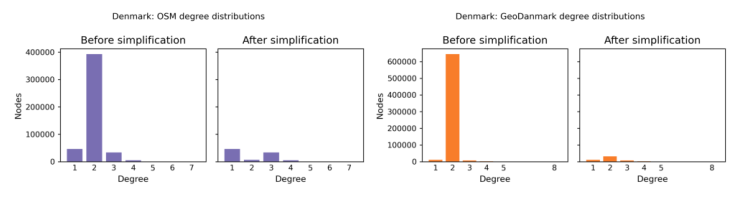

In [25]:
# Display already saved degree distribution plots

print("Note that the two figures below have different y-axis scales.")

plot_func.plot_saved_maps(
    [osm_results_plots_fp + "degree_dist_osm",
     ref_results_plots_fp + "degree_dist_reference"]
)

### Alpha, beta, and gamma indices

In this subsection, we compute and contrast the three aggregated network metrics alpha, beta, and gamma. These metrics are often used to describe network structure, but as measures of data quality, they are only meaningful when compared to the values of a corresponding data set. For this reason, alpha, beta, and gamma are only part of the extrinsic analysis and not included in the intrinsic notebooks.

While no conclusion can be drawn about data quality based on any of the three metrics by itself, a comparison of the metrics for the two data sets can indicate differences in network topology, and hence differences in how the infrastructure has been mapped.

#### Method
All three indices are computed with `eval_func.compute_alpha_beta_gamma`.

The **alpha** value is the ratio of actual to possible *cycles* in the network. A network cycle is defined as a closed loop - i.e. a path that ends on the same node that it started from. The value of alpha ranges from 0 to 1. An alpha value of 0 means that the network has no cycles at all, i.e. it is a tree. An alpha value of 1 means that the network is fully connected, which is very rarely the case.

The **beta** value is the ratio of existing edges to existing nodes in the network. The value of beta ranges from 0 to N-1, where N is the number of existing nodes. A beta value of 0 means that the network has no edges; a beta value of N-1 means that the network is fully connected (see also gamma value of 1). The higher the beta value, the more different paths (on average) can be chosen between any pair of nodes.

The **gamma** value is the ratio of existing to *possible* edges in the network. Any edge that connects two of the existing network nodes is defined as "possible". Hence, the value of gamma ranges from 0 to 1. A gamma value of 0 means that the network has no edges; a gamma value of 1 means that every node of the network is connected to every other node.

For all three indices, see [Ducruet and Rodrigue, 2020](https://transportgeography.org/contents/methods/graph-theory-measures-indices/). All three indices can be interpreted in respect to network connectivity: The higher the alpha value, the more cycles are present in the network; the higher the beta value, the higher the number of paths and thus the higher the complexity of the network; and the higher the gamma value, the fewer edges lie between any pair of nodes.

#### Interpretation
These metrics do not say much about the data quality itself, nor are they useful for a topological comparison of networks of similar size. However, some conclusions can be drawn through a comparison. For example, if the indices are very similar for the two networks, despite the networks e.g. having very different geometric lengths, this suggests that the data sets have been mapped in roughly the same way, but that one simply includes more features than the other. However, if the networks have roughly the same total geometric length, but the values from alpha, beta and gamma differ, this can be an indication that the structure and topology of the two data sets are fundamentally different.


In [26]:
osm_alpha, osm_beta, osm_gamma = eval_func.compute_alpha_beta_gamma(
    edges=osm_edges_simplified,
    nodes=osm_nodes_simplified,
    G=osm_graph_simplified,
    planar=True,
)  # We assume network to be planar or approximately planar

print(f"Alpha for the simplified OSM network: {osm_alpha:.2f}")
print(f"Beta for the simplified OSM network: {osm_beta:.2f}")
print(f"Gamma for the simplified OSM network: {osm_gamma:.2f}")

print("\n")

ref_alpha, ref_beta, ref_gamma = eval_func.compute_alpha_beta_gamma(
    ref_edges_simplified, ref_nodes_simplified, ref_graph_simplified, planar=True
)  # We assume network to be planar or approximately planar

print(f"Alpha for the simplified {reference_name} network: {ref_alpha:.2f}")
print(f"Beta for the simplified {reference_name} network: {ref_beta:.2f}")
print(f"Gamma for the simplified {reference_name} network: {ref_gamma:.2f}")

Alpha for the simplified OSM network: 0.05
Beta for the simplified OSM network: 0.98
Gamma for the simplified OSM network: 0.33


Alpha for the simplified GeoDanmark network: 0.04
Beta for the simplified GeoDanmark network: 0.99
Gamma for the simplified GeoDanmark network: 0.33


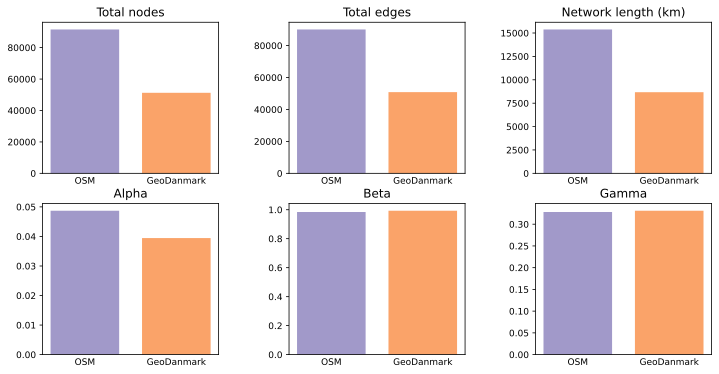

In [27]:
# Plot alpha, beta, gamma

set_renderer(renderer_plot)

bar_labels = ["OSM", reference_name]

bar_colors = [pdict["osm_base"], pdict["ref_base"]]

subplot_data = [
    (len(osm_nodes_simplified), len(ref_nodes_simplified)),
    (len(osm_edges_simplified), len(ref_edges_simplified)),
    (
        osm_edges_simplified.geometry.length.sum()/1000,
        ref_edges_simplified.geometry.length.sum()/1000,
    ),
    (osm_alpha, ref_alpha),
    (osm_beta, ref_beta),
    (osm_gamma, ref_gamma),
]
y_label = [
    "",
    "",
    "",
    "",
    "",
    "",
]
subplottitle = ["Total nodes", "Total edges", "Network length (km)", "Alpha", "Beta", "Gamma"]
filepath = compare_results_plots_fp + "alpha_beta_gamma"

plot = plot_func.make_bar_subplots(
    subplot_data=subplot_data,
    nrows=2,
    ncols=3,
    bar_labels=[["OSM", reference_name] for j in range(6)],
    y_label=y_label,
    x_positions=[[1,2] for j in range(6)],
    title=subplottitle,
    bar_colors=bar_colors,
    filepath=filepath,
    wspace=0.4
);

### Dangling nodes

In [28]:
osm_dangling_nodes = gpd.read_file(osm_results_data_fp + "dangling_nodes.gpkg")
ref_dangling_nodes = gpd.read_file(ref_results_data_fp + "dangling_nodes.gpkg")

**Dangling nodes in OSM & reference networks**

In [29]:
# Interactive plot of dangling nodes

if plot_interactive_maps:

    osm_edges_simplified_folium = plot_func.make_edgefeaturegroup(
        gdf=osm_edges_simplified,
        mycolor=pdict["osm_base"],
        myweight=pdict["line_base"],
        nametag="OSM edges",
        show_edges=True,
    )

    osm_nodes_simplified_folium = plot_func.make_nodefeaturegroup(
        gdf=osm_nodes_simplified,
        mysize=pdict["mark_base"],
        mycolor=pdict["osm_base"],
        nametag="OSM all nodes",
        show_nodes=True,
    )

    osm_dangling_nodes_folium = plot_func.make_nodefeaturegroup(
        gdf=osm_dangling_nodes,
        mysize=pdict["mark_emp"],
        mycolor=pdict["osm_contrast"],
        nametag="OSM dangling nodes",
        show_nodes=True,
    )

    ref_edges_simplified_folium = plot_func.make_edgefeaturegroup(
        gdf=ref_edges_simplified,
        mycolor=pdict["ref_base"],
        myweight=pdict["line_base"],
        nametag="Reference edges",
        show_edges=True,
    )

    ref_nodes_simplified_folium = plot_func.make_nodefeaturegroup(
        gdf=ref_nodes_simplified,
        mysize=pdict["mark_base"],
        mycolor=pdict["ref_base"],
        nametag="Reference all nodes",
        show_nodes=True,
    )

    ref_dangling_nodes_folium = plot_func.make_nodefeaturegroup(
        gdf=ref_dangling_nodes,
        mysize=pdict["mark_emp"],
        mycolor=pdict["ref_contrast2"],
        nametag="Reference dangling nodes",
        show_nodes=True,
    )

    m = plot_func.make_foliumplot(
        feature_groups=[
            osm_edges_simplified_folium,
            osm_nodes_simplified_folium,
            osm_dangling_nodes_folium,
            ref_edges_simplified_folium,
            ref_nodes_simplified_folium,
            ref_dangling_nodes_folium,
        ],
        layers_dict=folium_layers,
        center_gdf=osm_nodes_simplified,
        center_crs=osm_nodes_simplified.crs,
    )

    bounds = plot_func.compute_folium_bounds(osm_nodes_simplified)
    m.fit_bounds(bounds)
    m.save(compare_results_inter_maps_fp + "danglingmap_compare.html")

    display(m)

In [30]:
if plot_interactive_maps:

    print("Interactive map saved at " + compare_results_inter_maps_fp.lstrip("../") + "danglingmap_compare.html")

#### Local values for dangling nodes

In [31]:
# Compute pct difference relative to OSM

grid["dangling_nodes_diff_pct"] = np.round(
    100
    * (grid.count_ref_dangling_nodes - grid.count_osm_dangling_nodes)
    / grid.count_osm_dangling_nodes,
    2,
)

**Dangling nodes as percentage of all nodes**

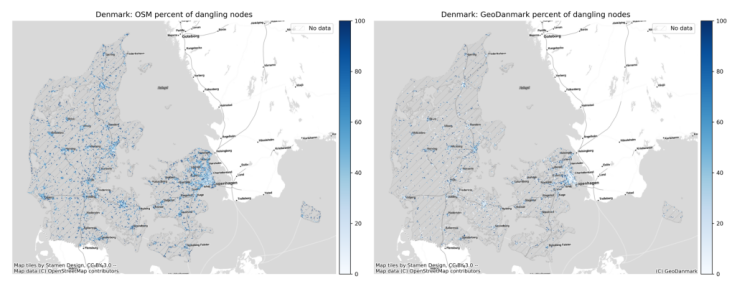

In [32]:
plot_func.plot_saved_maps(
    [
        osm_results_static_maps_fp + "pct_dangling_nodes_osm",
        ref_results_static_maps_fp + "pct_dangling_nodes_reference",
    ]
)

**Local differences in dangling nodes percentages**

In [33]:
# Plot

if plot_static_maps:
    
    set_renderer(renderer_map)

    # norm color bar
    cbnorm_dang_diff = colors.Normalize(vmin=-100, vmax=100)  # from -max to +max

    fig, ax = plt.subplots(1, figsize=pdict["fsmap"])
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3.5%", pad="1%")

    grid.plot(
        cax=cax,
        ax=ax,
        alpha=pdict["alpha_grid"],
        column="dangling_nodes_diff_pct",
        cmap=pdict["diff"],
        legend=True,
        norm=cbnorm_dang_diff,
    )

    # Add no data patches
    grid[grid["dangling_nodes_diff_pct"].isnull()].plot(
        cax=cax,
        ax=ax,
        facecolor=pdict["nodata_face"],
        edgecolor=pdict["nodata_edge"],
        linewidth= pdict["line_nodata"],
        hatch=pdict["nodata_hatch"],
        alpha=pdict["alpha_nodata"],
    )

    ax.legend(handles=[nodata_patch], loc="upper right")

    ax.set_title(
        area_name + f": {reference_name} percent difference to OSM in dangling nodes"
    )
    ax.set_axis_off()
    cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)

    plot_func.save_fig(fig, compare_results_static_maps_fp + "dangling_nodes_pct_diff_compare")

### Under/overshoots

In [34]:
# USER INPUT: LENGTH TOLERANCE FOR OVER- AND UNDERSHOOTS
length_tolerance_over = 3
length_tolerance_under = 3

for s in [length_tolerance_over, length_tolerance_under]:
    assert isinstance(s, int) or isinstance(s, float), print(
        "Settings must be integer or float values!"
    )

In [35]:
osm_overshoot_ids = pd.read_csv(
    osm_results_data_fp + f"overshoot_edges_{length_tolerance_over}.csv"
)["edge_id"].to_list()
osm_undershoot_ids = pd.read_csv(
    osm_results_data_fp + f"undershoot_nodes_{length_tolerance_under}.csv"
)["node_id"].to_list()

ref_overshoot_ids = pd.read_csv(
    ref_results_data_fp + f"overshoot_edges_{length_tolerance_over}.csv"
)["edge_id"].to_list()
ref_undershoot_ids = pd.read_csv(
    ref_results_data_fp + f"undershoot_nodes_{length_tolerance_under}.csv"
)["node_id"].to_list()

osm_overshoots = osm_edges_simplified.loc[
    osm_edges_simplified.edge_id.isin(osm_overshoot_ids)
]
ref_overshoots = ref_edges_simplified.loc[
    ref_edges_simplified.edge_id.isin(ref_overshoot_ids)
]
ref_undershoots = ref_nodes_simplified.loc[
    ref_nodes_simplified.nodeID.isin(ref_undershoot_ids)
]
osm_undershoots = osm_nodes_simplified.loc[
    osm_nodes_simplified.osmid.isin(osm_undershoot_ids)
]

**Over and undershoots in OSM and reference networks**

In [36]:
# Interactive plot of over/undershoots

if plot_interactive_maps:

    feature_groups = []

    # OSM feature groups
    osm_edges_simplified_folium = plot_func.make_edgefeaturegroup(
        gdf=osm_edges_simplified,
        mycolor=pdict["osm_base"],
        myweight=pdict["line_base"],
        nametag="OSM network",
        show_edges=True,
    )

    feature_groups.append(osm_edges_simplified_folium)


    if len(osm_overshoots) > 0:
        osm_overshoots_folium = plot_func.make_edgefeaturegroup(
            gdf=osm_overshoots,
            mycolor=pdict["osm_contrast"],
            myweight=pdict["line_emp"],
            nametag="OSM overshoots",
            show_edges=True,
        )

        feature_groups.append(osm_overshoots_folium)

    if len(osm_undershoots) > 0:
        osm_undershoot_nodes_folium = plot_func.make_nodefeaturegroup(
            gdf=osm_undershoots,
            mysize=pdict["mark_emp"],
            mycolor=pdict["osm_contrast2"],
            nametag="OSM undershoot nodes",
            show_nodes=True,
        )

        feature_groups.append(osm_undershoot_nodes_folium)


    # Reference feature groups
    ref_edges_simplified_folium = plot_func.make_edgefeaturegroup(
        gdf=ref_edges_simplified,
        mycolor=pdict["ref_base"],
        myweight=pdict["line_base"],
        nametag=f"{reference_name} network",
        show_edges=True,
    )

    feature_groups.append(ref_edges_simplified_folium)

    if len(ref_overshoots) > 0:
        ref_overshoots_folium = plot_func.make_edgefeaturegroup(
            gdf=ref_overshoots,
            mycolor=pdict["ref_contrast"],
            myweight=pdict["line_emp"],
            nametag=f"{reference_name} overshoots",
            show_edges=True,
        )

        feature_groups.append(ref_overshoots_folium)

    if len(ref_undershoots) > 0:

        ref_undershoot_nodes_folium = plot_func.make_nodefeaturegroup(
            gdf=ref_undershoots,
            mysize=pdict["mark_emp"],
            mycolor=pdict["ref_contrast2"],
            nametag=f"{reference_name} undershoot nodes",
            show_nodes=True,
        )

        feature_groups.append(ref_undershoot_nodes_folium)

    m = plot_func.make_foliumplot(
        feature_groups=feature_groups,
        layers_dict=folium_layers,
        center_gdf=osm_nodes_simplified,
        center_crs=osm_nodes_simplified.crs,
    )

    bounds = plot_func.compute_folium_bounds(osm_nodes_simplified)
    m.fit_bounds(bounds)

    m.save(
        compare_results_inter_maps_fp
        + f"overundershoots_{length_tolerance_over}_{length_tolerance_under}_compare.html"
    )

    display(m)

In [37]:
if plot_interactive_maps:

    print("Interactive map saved at " + compare_results_inter_maps_fp.lstrip("../")
        + f"overundershoots_{length_tolerance_over}_{length_tolerance_under}_compare.html")

## Network components

This section takes a close look at the network component characteristics for the two data sets.

Disconnected components do not share any elements (nodes/edges). In other words, there is no network path that could lead from one disconnected component to the other. As mentioned above, most real-world networks of bicycle infrastructure do consist of many disconnected components ([Natera Orozco et al., 2020](https://onlinelibrary.wiley.com/doi/pdfdirect/10.1111/gean.12324)). However, when two disconnected components are very close to each other, it might be a sign of a missing edge or another digitizing error.

**Method**

To compare the number and pattern of disconnected components in OSM and reference data, all component results from the intrinsic analyses are juxtaposed and two new plots showing respectively components gaps for OSM and reference data and the difference in component connectivity are produced.

**Interpretation**

The fragmented nature of many bicycle networks make it hard to assess whether disconnected components are a question of a lack of data quality of a lack of properly connected bicycle infrastructure. Comparing disconnected components in two data sets enables a more accurate assessment of whether a disconnected component is a data or a planning issue.

<br />

### Disconnected components

In [38]:
print(
    f"The OSM network in the study area consists of {osm_intrinsic_results['component_analysis']['component_count']} disconnected components."
)
print(
    f"The {reference_name} network in the study area consists of {ref_intrinsic_results['component_analysis']['component_count']} disconnected components."
)

The OSM network in the study area consists of 10355 disconnected components.
The GeoDanmark network in the study area consists of 4408 disconnected components.


In [39]:
if os.path.exists(osm_results_static_maps_fp + "all_components_osm") and os.path.exists(ref_results_static_maps_fp + "all_components_reference"):
    # checking if plots exists since these often fail for large data sets

    plot_func.plot_saved_maps(
        [
            osm_results_static_maps_fp + "all_components_osm",
            ref_results_static_maps_fp + "all_components_reference",
        ]
    )
else:
    print("Maps of all connected components not found!")

Maps of all connected components not found!


### Component length distribution

The distribution of all network component lengths can be visualized in a so-called *Zipf plot*, which orders the lengths of each component by rank, showing the largest component's length on the left, then the second largest component's length, etc., until the smallest component's length on the right. When a Zipf plot follows a straight line in [log-log scale](https://en.wikipedia.org/wiki/Logarithmic_scale), it means that there is a much higher chance to find small disconnected components than expected from traditional distributions [(Clauset et al., 2009)]( https://epubs.siam.org/doi/abs/10.1137/070710111). This can mean that there has been no consolidation of the network, only piece-wise or random additions [(Szell et al., 2022)](https://www.nature.com/articles/s41598-022-10783-y), or that the data itself suffers from many gaps and topology errors resulting in small disconnected components.

However, it can also happen that the largest connected component (the leftmost marker in the plot at rank $10^0$) is a clear outlier, while the rest of the plot follows a different shape. This can mean that at the infrastructure level, most of the infrastructure has been connected to one large component, and that the data reflects this - i.e. the data is not suffering from gaps and missing links to a large extent. Bicycle networks might also be somewhere inbetween, with several large components as outliers.

In case of a comparison over the same region, as shown below, if one data set shows a clear outlier in its largest connected component while the other does not, and if it is also at least as large, it can in general be interpreted as being more complete.

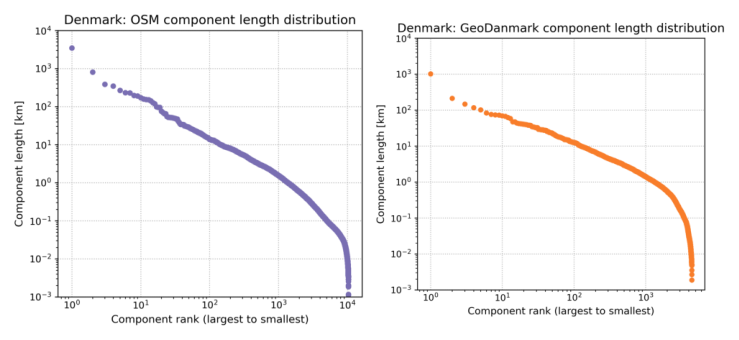

In [40]:
plot_func.plot_saved_maps(
    [
        osm_results_plots_fp + "component_length_distribution_osm",
        ref_results_plots_fp + "component_length_distribution_reference",
    ],
    figsize=pdict["fsmap"]
)

### Largest connected component

In [41]:
# Read largest cc
osm_largest_cc = gpd.read_parquet(osm_results_data_fp + "largest_connected_component.parquet")
ref_largest_cc = gpd.read_parquet(ref_results_data_fp + "largest_connected_component.parquet")

print(
    f"The largest connected component in the OSM network contains {osm_intrinsic_results['component_analysis']['largest_cc_pct_size']:.2f}% of the network length."
)
print(
    f"The largest connected component in the {reference_name} network contains {ref_intrinsic_results['component_analysis']['largest_cc_pct_size']:.2f}% of the network length."
)

The largest connected component in the OSM network contains 22.52% of the network length.
The largest connected component in the GeoDanmark network contains 11.73% of the network length.


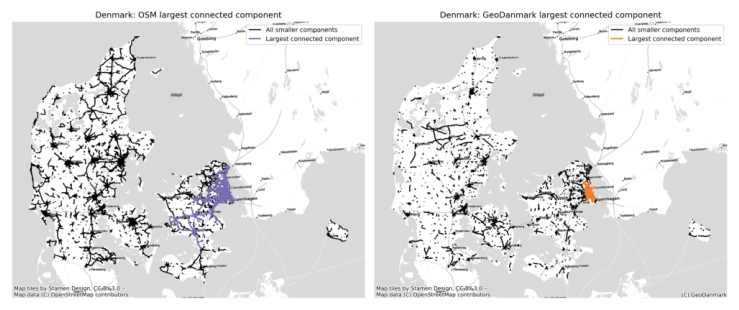

In [42]:
plot_func.plot_saved_maps(
    [
        osm_results_static_maps_fp + "largest_conn_comp_osm",
        ref_results_static_maps_fp + "largest_conn_comp_reference",
    ]
)

**Overlay of largest connected component in OSM and reference networks**

In [43]:
# Plot

if plot_static_maps:

    set_renderer(renderer_map)
    fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

    osm_largest_cc.plot(ax=ax, linewidth=3.5, color=pdict["osm_base"], label="OSM")
    ref_largest_cc.plot(ax=ax, linewidth=1.25, color=pdict["ref_base"], label=reference_name)

    ax.set_title(f" {area_name}: largest connected components")
    ax.set_axis_off()
    ax.legend()
    cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)

    plot_func.save_fig(fig, compare_results_static_maps_fp + "largest_cc_overlay_compare")

In [44]:
# Plot again for potential report titlepage

set_renderer(renderer_map)
fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

osm_largest_cc.plot(ax=ax, linewidth=3, color=pdict["osm_base"], label="OSM")
ref_largest_cc.plot(ax=ax, linewidth=1, color=pdict["ref_base"], label=reference_name)
ax.set_axis_off()

plot_func.save_fig(fig, compare_results_static_maps_fp + "titleimage",plot_res="high")
plt.close()

### Missing links
In the plot of potential missing links between components, all edges that are within the specified distance of an edge on another component are plotted. The gaps between disconnected edges are highlighted with a marker. The map thus highlights edges which, despite being in close proximity of each other, are disconnected and where it thus would not be possible to bike on cycling infrastructure between the edges.

In [45]:
# DEFINE MAX BUFFER DISTANCE BETWEEN COMPONENTS CONSIDERED A GAP/MISSING LINK
component_min_distance = 10

assert isinstance(component_min_distance, int) or isinstance(
    component_min_distance, float
), print("Setting must be integer or float value!")

In [46]:
# Read results with component gaps

osm_cg_edge_ids = pd.read_csv(
    osm_results_data_fp + f"component_gaps_edges_{component_min_distance}.csv"
)["edge_id"].to_list()
osm_component_gaps_edges = osm_edges_simplified.loc[
    osm_edges_simplified.edge_id.isin(osm_cg_edge_ids)
]

ref_cg_edge_ids = pd.read_csv(
    ref_results_data_fp + f"component_gaps_edges_{component_min_distance}.csv"
)["edge_id"].to_list()
ref_component_gaps_edges = ref_edges_simplified.loc[
    ref_edges_simplified.edge_id.isin(ref_cg_edge_ids)
]

osm_component_gaps = gpd.read_file(
    osm_results_data_fp + f"component_gaps_centroids_{component_min_distance}.gpkg"
)
ref_component_gaps = gpd.read_file(
    ref_results_data_fp + f"component_gaps_centroids_{component_min_distance}.gpkg"
)

In [47]:
# Interactive plot of adjacent components

if plot_interactive_maps:

    feature_groups = []

    if len(osm_component_gaps_edges) > 0:

        # Feature groups for OSM
        osm_edges_simplified_folium = plot_func.make_edgefeaturegroup(
            gdf=osm_edges_simplified,
            mycolor=pdict["osm_base"],
            myweight=pdict["line_base"],
            nametag="OSM network",
            show_edges=True,
        )

        osm_component_gaps_edges_folium = plot_func.make_edgefeaturegroup(
            gdf=osm_component_gaps_edges,
            mycolor=pdict["osm_emp"],
            myweight=pdict["line_emp"],
            nametag="OSM: Adjacent disconnected edges",
            show_edges=True,
        )

        osm_component_gaps_folium = plot_func.make_markerfeaturegroup(
            gdf=osm_component_gaps, nametag="OSM: Component gaps", show_markers=True
        )

        feature_groups.extend(
            [
                osm_edges_simplified_folium,
                osm_component_gaps_edges_folium,
                osm_component_gaps_folium,
            ]
        )

    # Feature groups for reference
    if len(ref_component_gaps_edges) > 0:

        ref_edges_simplified_folium = plot_func.make_edgefeaturegroup(
            gdf=ref_edges_simplified,
            mycolor=pdict["ref_base"],
            myweight=pdict["line_base"],
            nametag=f"{reference_name} network",
            show_edges=True,
        )

        ref_component_gaps_edges_folium = plot_func.make_edgefeaturegroup(
            gdf=ref_component_gaps_edges,
            mycolor=pdict["ref_emp"],
            myweight=pdict["line_emp"],
            nametag=f"{reference_name}: Adjacent disconnected edges",
            show_edges=True,
        )

        ref_component_gaps_folium = plot_func.make_markerfeaturegroup(
            gdf=ref_component_gaps, nametag=f"{reference_name}: Component gaps", show_markers=True
        )

        feature_groups.extend(
            [
                ref_edges_simplified_folium,
                ref_component_gaps_edges_folium,
                ref_component_gaps_folium,
            ]
        )

    m = plot_func.make_foliumplot(
        feature_groups=feature_groups,
        layers_dict=folium_layers,
        center_gdf=osm_nodes_simplified,
        center_crs=osm_nodes_simplified.crs,
    )

    bounds = plot_func.compute_folium_bounds(osm_nodes_simplified)
    m.fit_bounds(bounds)
    m.save(compare_results_inter_maps_fp + "component_gaps_compare.html")

    display(m)

In [48]:
if plot_interactive_maps:   
    print("Interactive map saved at " + compare_results_inter_maps_fp.lstrip("../") + "component_gaps_compare.html")

### Components per grid cell

The plots below show the number of components intersecting a grid cell. A high number of components in a grid cell is generally an indication of poor network connectivity - either due to fragmented infrastructure or because of problems with the data quality.

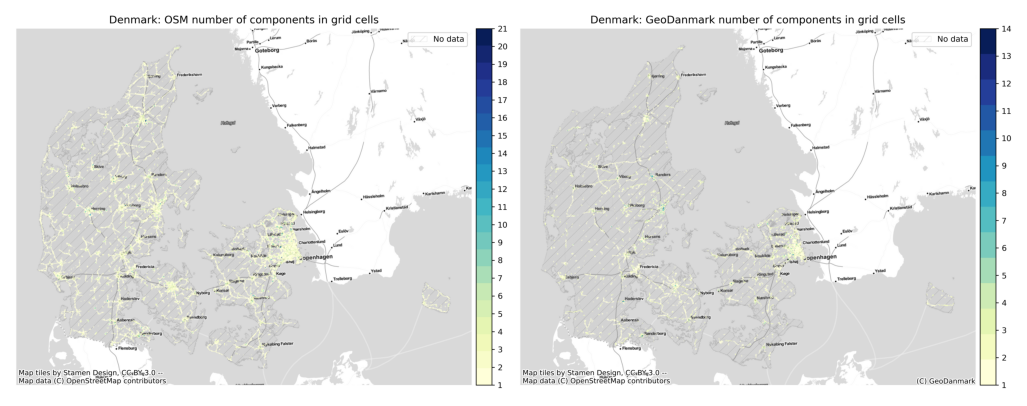

In [49]:
plot_func.plot_saved_maps(
    [
        osm_results_static_maps_fp + "number_of_components_in_grid_cells_osm",
        ref_results_static_maps_fp + "number_of_components_in_grid_cells_reference",
    ]
)

### Component connectivity

Here we visualize differences between how many cells can be reached from each cell. The metric is a crude measure for network connectivity but has the benefit of being computationally cheap and thus able to quickly highlight stark differences in network connectivity.

In the plot showing the difference in percent cells reached, positive values indicate a higher connectivity using the reference data set, while negative values means that more cells can be reached from a particular cell in the OSM data.

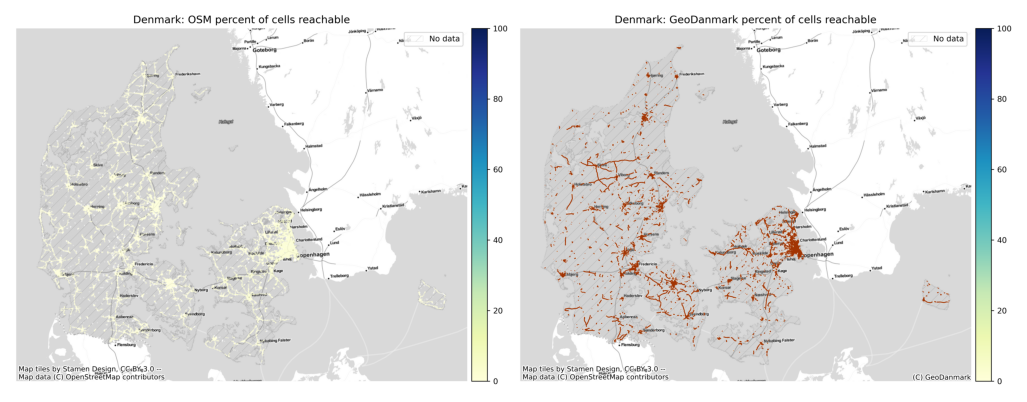

In [50]:
plot_func.plot_saved_maps(
    [
        osm_results_static_maps_fp + "percent_cells_reachable_grid_osm",
        ref_results_static_maps_fp + "percent_cells_reachable_grid_reference",
    ]
)

In [51]:
# Compute difference in cell reach percentage (where data for both OSM and REF is available)

grid["cell_reach_pct_diff"] = (
    grid["cells_reached_ref_pct"] - grid["cells_reached_osm_pct"]
)

In [52]:
# Plot

if plot_static_maps:
    
    set_renderer(renderer_map)

    # norm color bar
    cbnorm_diff = colors.Normalize(vmin=-100, vmax=100)

    fig, ax = plt.subplots(1, figsize=pdict["fsmap"])
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3.5%", pad="1%")

    grid.plot(
        cax=cax,
        ax=ax,
        alpha=pdict["alpha_grid"],
        column="cell_reach_pct_diff",
        cmap=pdict["diff"],
        legend=True,
        norm=cbnorm_diff,
    )

    # Add no data patches
    grid[grid["cell_reach_pct_diff"].isnull()].plot(
        cax=cax,
        ax=ax,
        facecolor=pdict["nodata_face"],
        edgecolor=pdict["nodata_edge"],
        linewidth= pdict["line_nodata"],
        hatch=pdict["nodata_hatch"],
        alpha=pdict["alpha_nodata"],
    )

    # osm_edges_simplified.plot(ax=ax, color=pdict["osm_base"], alpha=1,linewidth=2)
    # ref_edges_simplified.plot(ax=ax, color=pdict["ref_base"], alpha=1,linewidth=1)

    ax.legend(handles=[nodata_patch], loc="upper right")

    ax.set_title(
        f"{area_name}: {reference_name} difference to OSM in percent of cells reached"
    )
    ax.set_axis_off()
    cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)

    plot_func.save_fig(fig, compare_results_static_maps_fp + "percent_cell_reached_diff_compare")

## Summary

In [53]:
# Load results from intrinsic
osm_intrinsic_df = pd.read_csv(
    osm_results_data_fp + "intrinsic_summary_results.csv",
    index_col=0,
    names=["OSM"],
    header=0,
)

ref_intrinsic_df = pd.read_csv(
    ref_results_data_fp + "intrinsic_summary_results.csv",
    index_col=0,
    names=[reference_name],
    header=0,
)

# Drop rows from OSM results not available for reference
no_compare = ["Incompatible tag combinations", "Missing intersection nodes"]
drop_cols = [n for n in no_compare if n in osm_intrinsic_df.index]
osm_intrinsic_df.drop(
    drop_cols,
    axis=0,
    inplace=True,
)

# Save new results
osm_intrinsic_df.at["Alpha", "OSM"] = osm_alpha
osm_intrinsic_df.at["Beta", "OSM"] = osm_beta
osm_intrinsic_df.at["Gamma", "OSM"] = osm_gamma

ref_intrinsic_df.at["Alpha", reference_name] = ref_alpha
ref_intrinsic_df.at["Beta", reference_name] = ref_beta
ref_intrinsic_df.at["Gamma", reference_name] = ref_gamma

# Combine   
extrinsic_df = osm_intrinsic_df.join(ref_intrinsic_df)
assert len(extrinsic_df) == len(osm_intrinsic_df) == len(ref_intrinsic_df)
extrinsic_df.style.pipe(format_extrinsic_style)

,OSM,GeoDanmark
Total infrastructure length (km),"20,583","8,676"
Protected bicycle infrastructure density (m/km2),382,92
Unprotected bicycle infrastructure density (m/km2),61,95
Mixed protection bicycle infrastructure density (m/km2),1,0
Bicycle infrastructure density (m/km2),444,187
Nodes,"91,521","51,224"
Dangling nodes,"46,593","11,218"
Nodes per km2,2,1
Dangling nodes per km2,1,0
Overshoots,86,99


## Save results

In [54]:
extrinsic_df.to_csv(
    compare_results_data_fp + "extrinsic_summary_results.csv", index=True
)

with open(
    compare_results_data_fp + f"grid_results_extrinsic.pickle", "wb"
) as f:
    pickle.dump(grid, f)

***

In [55]:
from time import strftime
print("Time of analysis: " + strftime("%a, %d %b %Y %H:%M:%S"))

Time of analysis: Tue, 14 Mar 2023 20:17:16
